In [1]:
!pip install ultralytics opencv-python numpy pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 96.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 109.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [2]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Looking in indexes: https://download.pytorch.org/whl/cu118


In [4]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110460 sha256=5fd1d8eeafafdc8c84cb082dd088d2bb9d8ef14c2370c4b053c6a55f8f7f19c7
  Stored in directory: /root/.cache/pip/wheels/12/dc/3c/e12983eac132d00f82a20c6cbe7b42ce6e96190ef8fa2d15e1
Successfully built filterpy


In [5]:
import cv2
import numpy as np
import pandas as pd
from ultralytics import YOLO
from collections import defaultdict, deque
import json
import matplotlib.pyplot as plt
from google.colab import files
from google.colab.patches import cv2_imshow
import torch
from filterpy.kalman import KalmanFilter
from sklearn.metrics.pairwise import cosine_similarity
import os

In [6]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
os.listdir('/content/drive/My Drive/Colab Notebooks')

['Untitled0.ipynb',
 'Copy of Untitled2 (1).ipynb',
 'SIHSANTRANENG.ipynb',
 'Untitled (2)',
 'Untitled1.ipynb',
 'Copy of Untitled2.ipynb',
 'Untitled (1)',
 'Untitled2.ipynb',
 'Untitled4.ipynb',
 'Untitled3.ipynb',
 'Copy of En_Sn_language_translation.ipynb',
 'Untitled5.ipynb',
 'En_Sn_language_translation.ipynb',
 'Untitled6.ipynb',
 'Copy of Untitled1.ipynb',
 'templates',
 '.ipynb_checkpoints',
 'static',
 'tf_model',
 'Copy of Untitled4.ipynb',
 'Untitled7.ipynb',
 'Untitled8.ipynb',
 'Untitled9.ipynb',
 'Untitled10.ipynb',
 'Untitled11.ipynb',
 'Untitled',
 'Untitled12.ipynb',
 'Untitled13.ipynb',
 '15sec_input_720p.mp4',
 'best.pt',
 'Untitled14.ipynb']

In [8]:
model_path = "/content/drive/My Drive/Colab Notebooks/best.pt"  # Your exact model filename
video_path = "/content/drive/My Drive/Colab Notebooks/15sec_input_720p.mp4"  # Your exact video filename

# Verify the files exist

assert os.path.exists(model_path), f"Model file not found: {model_path}"
assert os.path.exists(video_path), f"Video file not found: {video_path}"

print(f" Model loaded: {model_path}")
print(f" Video loaded: {video_path}")

 Model loaded: /content/drive/My Drive/Colab Notebooks/best.pt
 Video loaded: /content/drive/My Drive/Colab Notebooks/15sec_input_720p.mp4


In [9]:
class AdvancedPlayerTracker:
    def __init__(self, model_path, confidence_threshold=0.5, iou_threshold=0.7):
        """
        Initialize the advanced player tracker with YOLOv11 model

        Args:
            model_path: Path to your fine-tuned best.pt model
            confidence_threshold: Minimum confidence for detections
            iou_threshold: IoU threshold for tracking
        """
        self.model = YOLO(model_path)
        self.confidence_threshold = confidence_threshold
        self.iou_threshold = iou_threshold

        # Tracking data structures
        self.track_history = defaultdict(lambda: deque(maxlen=50))
        self.player_states = {}
        self.exit_events = []
        self.entry_events = []
        self.player_features = {}  # Store appearance features
        self.kalman_filters = {}   # Kalman filters for smooth tracking

        # Advanced tracking parameters
        self.max_disappeared = 30  # Max frames before considering player lost
        self.min_track_length = 5  # Minimum track length for valid detection

    def create_kalman_filter(self):
        """Create Kalman filter for position prediction"""
        kf = KalmanFilter(dim_x=4, dim_z=2)

        # State transition matrix (constant velocity model)
        kf.F = np.array([[1, 0, 1, 0],
                         [0, 1, 0, 1],
                         [0, 0, 1, 0],
                         [0, 0, 0, 1]], dtype=float)

        # Measurement matrix
        kf.H = np.array([[1, 0, 0, 0],
                         [0, 1, 0, 0]], dtype=float)

        # Measurement noise
        kf.R *= 10

        # Process noise
        kf.Q *= 0.1

        return kf

    def extract_appearance_features(self, frame, bbox):
        """Extract appearance features for re-identification"""
        x1, y1, x2, y2 = map(int, bbox)

        # Ensure coordinates are within frame bounds
        h, w = frame.shape[:2]
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(w, x2), min(h, y2)

        if x2 <= x1 or y2 <= y1:
            return np.zeros(128)  # Return zero vector for invalid bbox

        # Extract player region
        player_region = frame[y1:y2, x1:x2]

        if player_region.size == 0:
            return np.zeros(128)

        # Resize to standard size and extract color histogram
        player_resized = cv2.resize(player_region, (64, 128))

        # Extract color features (HSV histogram)
        hsv = cv2.cvtColor(player_resized, cv2.COLOR_BGR2HSV)
        hist_h = cv2.calcHist([hsv], [0], None, [32], [0, 180])
        hist_s = cv2.calcHist([hsv], [1], None, [32], [0, 256])
        hist_v = cv2.calcHist([hsv], [2], None, [32], [0, 256])

        # Combine histograms
        features = np.concatenate([hist_h.flatten(), hist_s.flatten(), hist_v.flatten()])

        # Normalize features
        if np.linalg.norm(features) > 0:
            features = features / np.linalg.norm(features)

        return features

    def is_player_in_frame(self, bbox, frame_width, frame_height, margin=20):
        """Enhanced frame boundary detection with adaptive margins"""
        x1, y1, x2, y2 = bbox

        # Calculate bounding box center and size
        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2
        bbox_width = x2 - x1
        bbox_height = y2 - y1

        # Adaptive margin based on bounding box size
        adaptive_margin = max(margin, min(bbox_width, bbox_height) * 0.1)

        # Check if center is within frame boundaries
        if (center_x < adaptive_margin or center_y < adaptive_margin or
            center_x > frame_width - adaptive_margin or center_y > frame_height - adaptive_margin):
            return False

        # Check if significant portion of bbox is outside frame
        visible_area = max(0, min(x2, frame_width) - max(x1, 0)) * max(0, min(y2, frame_height) - max(y1, 0))
        total_area = bbox_width * bbox_height

        if total_area > 0 and visible_area / total_area < 0.7:  # Less than 70% visible
            return False

        return True


    def match_players_with_reid(self, current_features, threshold=0.8):
        """Match players using appearance features for re-identification"""
        if not self.player_features or not current_features:
            return None

        best_match = None
        best_similarity = 0

        for player_id, stored_features in self.player_features.items():
            if len(stored_features) == 0:
                continue

            # Compare with recent features
            recent_features = stored_features[-5:]  # Use last 5 feature vectors
            similarities = []

            for features in recent_features:
                if len(features) == len(current_features):
                    sim = cosine_similarity([current_features], [features])[0][0]
                    similarities.append(sim)

            if similarities:
                avg_similarity = np.mean(similarities)
                if avg_similarity > best_similarity and avg_similarity > threshold:
                    best_similarity = avg_similarity
                    best_match = player_id

        return best_match if best_match else None

    def process_video(self, video_path, output_path=None, show_progress=True):
        """Process video with advanced tracking features"""
        cap = cv2.VideoCapture(video_path)

        # Get video properties
        fps = int(cap.get(cv2.CAP_PROP_FPS))
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        print(f"Video properties: {width}x{height}, {fps} FPS, {total_frames} frames")

        # Setup video writer if output path provided
        if output_path:
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

        frame_count = 0
        frames_for_display = []  # Store frames for visualization

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            # Run YOLOv11 inference with tracking
            results = self.model.track(
                frame,
                persist=True,
                verbose=False,
                conf=self.confidence_threshold,
                iou=self.iou_threshold
            )

            annotated_frame = frame.copy()

            if results[0].boxes is not None and results[0].boxes.id is not None:
                # Get detection data
                boxes = results[0].boxes.xywh.cpu().numpy()
                track_ids = results[0].boxes.id.cpu().numpy().astype(int)
                confidences = results[0].boxes.conf.cpu().numpy()

                # Convert xywh to xyxy format
                xyxy_boxes = []
                for box in boxes:
                    x_center, y_center, w, h = box
                    x1 = x_center - w/2
                    y1 = y_center - h/2
                    x2 = x_center + w/2
                    y2 = y_center + h/2
                    xyxy_boxes.append([x1, y1, x2, y2])

                # Process each detected player
                for i, (track_id, bbox, conf) in enumerate(zip(track_ids, xyxy_boxes, confidences)):
                    if conf < self.confidence_threshold:
                        continue

                    # Initialize Kalman filter for new players
                    if track_id not in self.kalman_filters:
                        self.kalman_filters[track_id] = self.create_kalman_filter()
                        # Initialize with first detection
                        center_x = (bbox[0] + bbox[2]) / 2
                        center_y = (bbox[1] + bbox[3]) / 2
                        self.kalman_filters[track_id].x = np.array([center_x, center_y, 0, 0])
                        self.player_features[track_id] = deque(maxlen=10)

                    # Update Kalman filter
                    center_x = (bbox[0] + bbox[2]) / 2
                    center_y = (bbox[1] + bbox[3]) / 2
                    self.kalman_filters[track_id].predict()
                    self.kalman_filters[track_id].update([center_x, center_y])

                    # Extract appearance features
                    features = self.extract_appearance_features(frame, bbox)
                    self.player_features[track_id].append(features)

                    # Update tracking history
                    self.track_history[track_id].append((center_x, center_y))

                    # Check if player is in frame
                    in_frame = self.is_player_in_frame(bbox, width, height)

                    # Track state changes
                    if track_id not in self.player_states:
                        self.player_states[track_id] = in_frame
                        if in_frame:
                            self.entry_events.append({
                                'player_id': int(track_id), # Convert to int
                                'frame': int(frame_count), # Convert to int
                                'timestamp': float(frame_count / fps), # Convert to float
                                'event': 'initial_appearance',
                                'confidence': float(conf),
                                'bbox': [float(b) for b in bbox] # Convert to float
                            })
                    else:
                        previous_state = self.player_states[track_id]

                        # Player left frame
                        if previous_state and not in_frame:
                            self.exit_events.append({
                                'player_id': int(track_id), # Convert to int
                                'frame': int(frame_count), # Convert to int
                                'timestamp': float(frame_count / fps), # Convert to float
                                'event': 'exit_frame',
                                'confidence': float(conf),
                                'bbox': [float(b) for b in bbox] # Convert to float
                            })

                        # Player re-entered frame
                        elif not previous_state and in_frame:
                            self.entry_events.append({
                                'player_id': int(track_id), # Convert to int
                                'frame': int(frame_count), # Convert to int
                                'timestamp': float(frame_count / fps), # Convert to float
                                'event': 'reenter_frame',
                                'confidence': float(conf),
                                'bbox': [float(b) for b in bbox] # Convert to float
                            })

                    self.player_states[track_id] = in_frame

                    # Draw annotations
                    x1, y1, x2, y2 = map(int, bbox)

                    # Color coding: Green for in-frame, Red for out-of-frame, Blue for tracking
                    if in_frame:
                        color = (0, 255, 0)  # Green
                        status = "IN"
                    else:
                        color = (0, 0, 255)  # Red
                        status = "OUT"

                    # Draw bounding box
                    cv2.rectangle(annotated_frame, (x1, y1), (x2, y2), color, 2)

                    # Draw tracking trail
                    if len(self.track_history[track_id]) > 1:
                        points = np.array(self.track_history[track_id], dtype=np.int32)
                        cv2.polylines(annotated_frame, [points], False, (255, 0, 255), 2)

                    # Draw player ID and status
                    label = f"Player {track_id}: {status} ({conf:.2f})"
                    cv2.putText(annotated_frame, label, (x1, y1-10),
                              cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

                    # Draw Kalman prediction
                    pred_x, pred_y = self.kalman_filters[track_id].x[:2]
                    cv2.circle(annotated_frame, (int(pred_x), int(pred_y)), 5, (255, 255, 0), -1)


            # Add frame info
            cv2.putText(annotated_frame, f"Frame: {frame_count}/{total_frames}",
                       (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
            cv2.putText(annotated_frame, f"Time: {frame_count/fps:.2f}s",
                       (10, 70), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

            # Store frames for visualization (every 30 frames to save memory)
            if frame_count % 30 == 0:
                frames_for_display.append(annotated_frame.copy())

            # Write frame if output requested
            if output_path:
                out.write(annotated_frame)

            frame_count += 1

            # Progress indicator
            if show_progress and frame_count % 30 == 0:
                progress = (frame_count / total_frames) * 100
                print(f"Processed {frame_count}/{total_frames} frames ({progress:.1f}%)")


        # Cleanup
        cap.release()
        if output_path:
            out.release()

        return self.generate_advanced_report(), frames_for_display

    def generate_advanced_report(self):
        """Generate comprehensive tracking report with advanced analytics"""
        report = {
            'summary': {
                'total_exit_events': len(self.exit_events),
                'total_entry_events': len(self.entry_events),
                'unique_players_tracked': len(self.player_states),
                'total_state_changes': len(self.exit_events) + len(self.entry_events)
            },
            'exit_events': self.exit_events,
            'entry_events': self.entry_events,
            'player_summary': {},
            'analytics': {}
        }

        # Generate per-player summary
        for player_id in self.player_states.keys():
            exits = [e for e in self.exit_events if e['player_id'] == player_id]
            entries = [e for e in self.entry_events if e['player_id'] == player_id]

            # Calculate time spent in/out of frame
            total_time_in = 0
            total_time_out = 0

            if entries and exits:
                for i, entry in enumerate(entries):
                    if i < len(exits):
                        time_in_frame = exits[i]['timestamp'] - entry['timestamp']
                        total_time_in += max(0, time_in_frame)

                    if i > 0:
                        time_out_frame = entry['timestamp'] - exits[i-1]['timestamp']
                        total_time_out += max(0, time_out_frame)

            report['player_summary'][f'player_{player_id}'] = {
                'exit_count': len(exits),
                'entry_count': len(entries),
                'exit_times': [e['timestamp'] for e in exits],
                'entry_times': [e['timestamp'] for e in entries],
                'total_time_in_frame': float(total_time_in), # Convert to float
                'total_time_out_frame': float(total_time_out), # Convert to float
                'avg_confidence': float(np.mean([e['confidence'] for e in exits + entries])) if exits + entries else 0.0 # Convert to float
            }

        # Advanced analytics
        if self.exit_events or self.entry_events:
            all_events = self.exit_events + self.entry_events
            timestamps = [e['timestamp'] for e in all_events]

            report['analytics'] = {
                'most_active_period': {
                    'start_time': float(min(timestamps)) if timestamps else 0.0, # Convert to float
                    'end_time': float(max(timestamps)) if timestamps else 0.0 # Convert to float
                },
                'average_events_per_second': float(len(all_events) / max(timestamps)) if timestamps else 0.0, # Convert to float
                'player_activity_distribution': {
                    f'player_{pid}': int(len([e for e in all_events if e['player_id'] == pid])) # Convert to int
                    for pid in self.player_states.keys()
                }
            }

        return report

    def visualize_results(self, frames_for_display, report):
        """Visualize tracking results with plots and sample frames"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Event timeline
        if self.exit_events or self.entry_events:
            exit_times = [e['timestamp'] for e in self.exit_events]
            entry_times = [e['timestamp'] for e in self.entry_events]

            axes[0, 0].scatter(exit_times, ['Exit'] * len(exit_times), c='red', alpha=0.7, s=50)
            axes[0, 0].scatter(entry_times, ['Entry'] * len(entry_times), c='green', alpha=0.7, s=50)
            axes[0, 0].set_xlabel('Time (seconds)')
            axes[0, 0].set_title('Player Entry/Exit Events Timeline')
            axes[0, 0].grid(True, alpha=0.3)

        # Player activity distribution
        if report['player_summary']:
            player_ids = list(report['player_summary'].keys())
            exit_counts = [report['player_summary'][pid]['exit_count'] for pid in player_ids]
            entry_counts = [report['player_summary'][pid]['entry_count'] for pid in player_ids]

            x = np.arange(len(player_ids))
            width = 0.35

            axes[0, 1].bar(x - width/2, exit_counts, width, label='Exits', color='red', alpha=0.7)
            axes[0, 1].bar(x + width/2, entry_counts, width, label='Entries', color='green', alpha=0.7)
            axes[0, 1].set_xlabel('Players')
            axes[0, 1].set_ylabel('Count')
            axes[0, 1].set_title('Player Activity Distribution')
            axes[0, 1].set_xticks(x)
            axes[0, 1].set_xticklabels(player_ids, rotation=45)
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)


        if self.exit_events or self.entry_events:
            all_confidences = [e['confidence'] for e in self.exit_events + self.entry_events]
            axes[1, 0].hist(all_confidences, bins=20, alpha=0.7, color='blue')
            axes[1, 0].set_xlabel('Confidence Score')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].set_title('Detection Confidence Distribution')
            axes[1, 0].grid(True, alpha=0.3)

        # Sample frame
        if frames_for_display:
            sample_frame = frames_for_display[len(frames_for_display)//2]
            axes[1, 1].imshow(cv2.cvtColor(sample_frame, cv2.COLOR_BGR2RGB))
            axes[1, 1].set_title('Sample Tracking Frame')
            axes[1, 1].axis('off')

        plt.tight_layout()
        plt.show()


        print("\nSample tracking frames:")
        for i, frame in enumerate(frames_for_display[:3]):  # Show first 3 frames
            print(f"Frame {i+1}:")
            cv2_imshow(frame)

Initializing Advanced Player Tracker...
Processing video...
Video properties: 1280x720, 25 FPS, 375 frames
requirements: Ultralytics requirement ['lap>=0.5.12'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 0.6s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

Processed 30/375 frames (8.0%)
Processed 60/375 frames (16.0%)
Processed 90/375 frames (24.0%)
Processed 120/375 frames (32.0%)
Processed 150/375 frames (40.0%)
Processed 180/375 frames (48.0%)
Processed 210/375 frames (56.0%)
Processed 240/375 frames (64.0%)
Processed 270/375 frames (72.0%)
Processed 300/375 frames (80.0%)
Processed 330/375 frames (88.0%)
Processed 360/375 frames (96.0%)
Generating reports...

ADVANCED TRACKING SUMMARY
Total players tracked: 94
Total exit events: 21
Total entry events: 95
Total state changes: 116

DETAILED EVENTS
 Player 12 exited at 0.04s (confidence: 0.89)
 Player 11 exited at 0.44s (confidence: 0.87)
 Player 5 exited at 3.04s (con

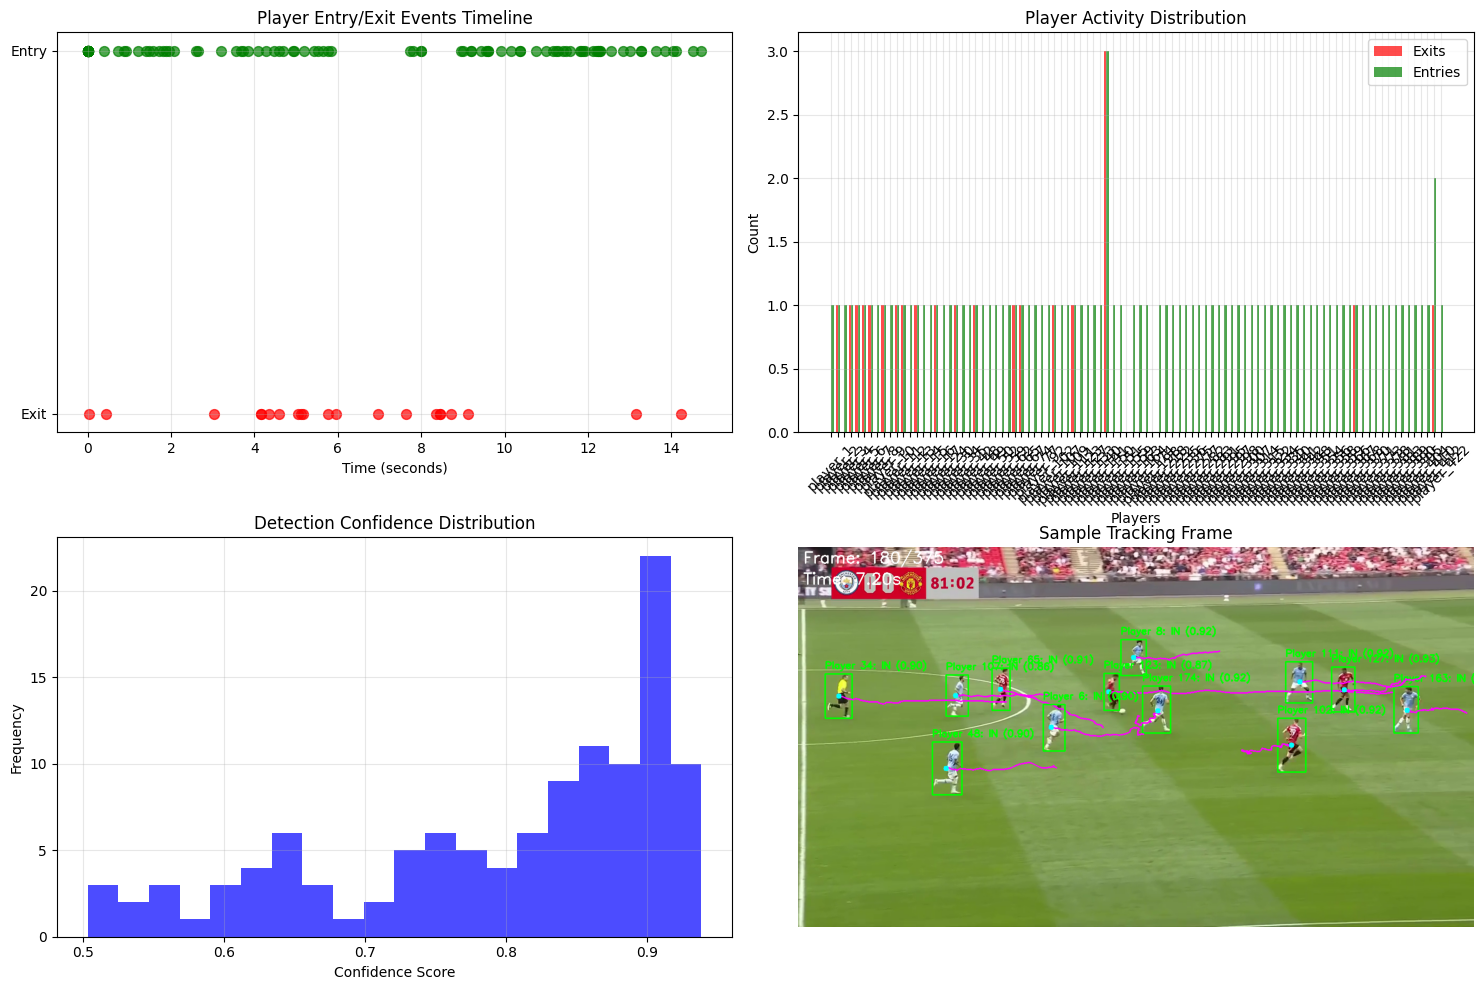


Sample tracking frames:
Frame 1:


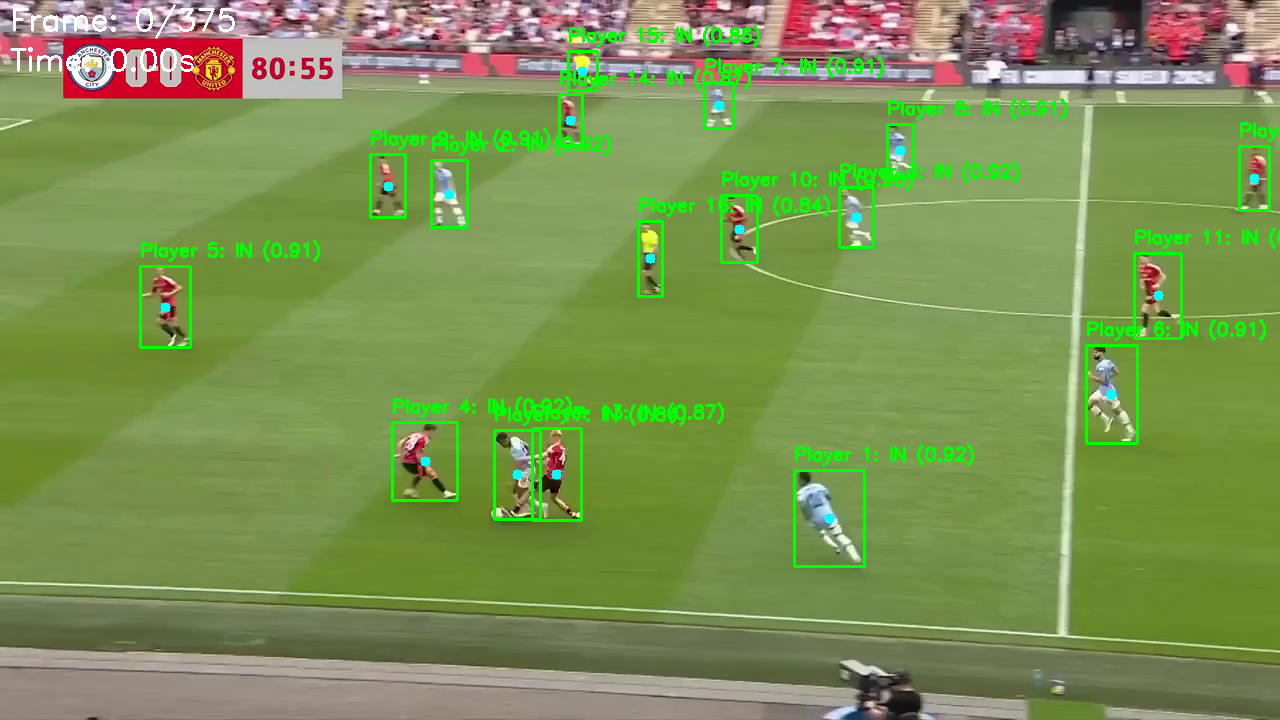

Frame 2:


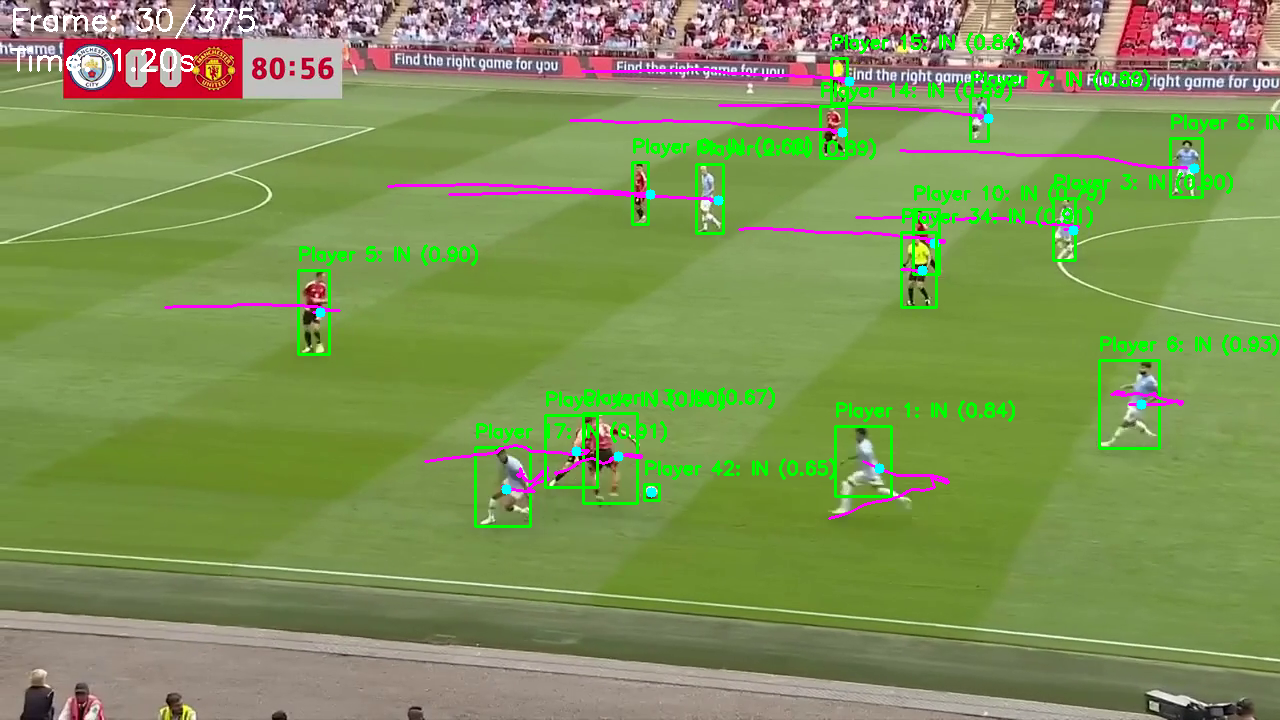

Frame 3:


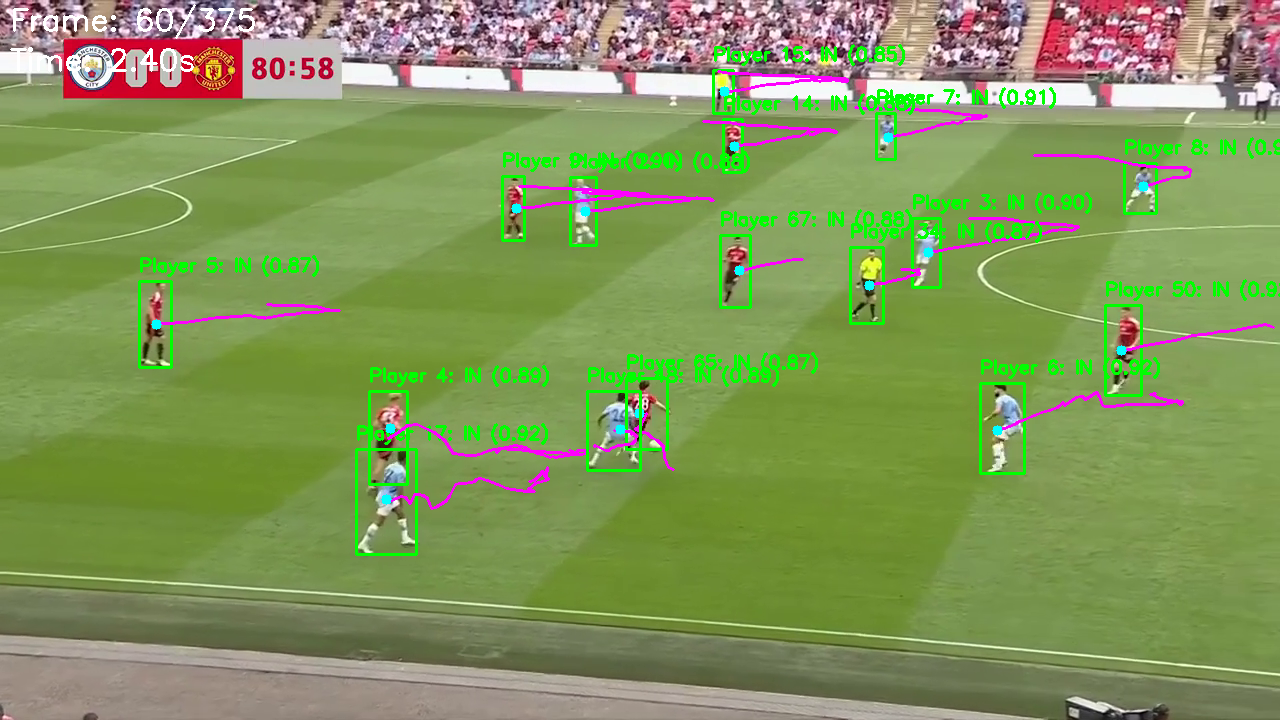

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Initialize the advanced tracker
print("Initializing Advanced Player Tracker...")
tracker = AdvancedPlayerTracker(
    model_path=model_path,
    confidence_threshold=0.5,
    iou_threshold=0.7
)

# Process the video
print("Processing video...")
report, sample_frames = tracker.process_video(
    video_path,
    output_path='tracked_output.mp4',  # Will save annotated video
    show_progress=True
)

# Generate and save detailed report
print("Generating reports...")
with open('advanced_tracking_report.json', 'w') as f:
    json.dump(report, f, indent=2)

# Create CSV report for easy analysis
events_data = []
for event in report['exit_events'] + report['entry_events']:
    events_data.append({
        'player_id': event['player_id'],
        'event_type': event['event'],
        'timestamp': event['timestamp'],
        'frame': event['frame'],
        'confidence': event['confidence']
    })

df = pd.DataFrame(events_data)
df.to_csv('tracking_events.csv', index=False)

# Display results
print("\n" + "="*50)
print("ADVANCED TRACKING SUMMARY")
print("="*50)
print(f"Total players tracked: {report['summary']['unique_players_tracked']}")
print(f"Total exit events: {report['summary']['total_exit_events']}")
print(f"Total entry events: {report['summary']['total_entry_events']}")
print(f"Total state changes: {report['summary']['total_state_changes']}")

print("\n" + "="*50)
print("DETAILED EVENTS")
print("="*50)
for event in report['exit_events']:
    print(f" Player {event['player_id']} exited at {event['timestamp']:.2f}s (confidence: {event['confidence']:.2f})")

for event in report['entry_events']:
    print(f" Player {event['player_id']} entered at {event['timestamp']:.2f}s (confidence: {event['confidence']:.2f})")

print("\n" + "="*50)
print("PLAYER STATISTICS")
print("="*50)
for player_id, stats in report['player_summary'].items():
    print(f"\n{player_id.upper()}:")
    print(f"  - Exit events: {stats['exit_count']}")
    print(f"  - Entry events: {stats['entry_count']}")
    print(f"  - Time in frame: {stats['total_time_in_frame']:.2f}s")
    print(f"  - Time out of frame: {stats['total_time_out_frame']:.2f}s")
    print(f"  - Average confidence: {stats['avg_confidence']:.2f}")

# Visualize results
tracker.visualize_results(sample_frames, report)

# Download results
print("\nDownloading results...")
files.download('advanced_tracking_report.json')
files.download('tracking_events.csv')
files.download('tracked_output.mp4')
